# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces

import os
datadir = "/content/Exam"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/exam/cifar-10-batches-py" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/MyDrive/exam/cifar-10-batches-py


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from PIL import Image

def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1: # 90 degrees rotation
        return torch.rot90(img, k=1, dims=(1, 2))
    elif rot == 2: # 180 degrees rotation
        return torch.rot90(img, k=2, dims=(1, 2))
    elif rot == 3: # 270 degrees rotation
        return torch.rot90(img, k=3, dims=(1, 2))
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

# def rotate_img(img, rotation_label):
#     pil_img = transforms.ToPILImage()(img)
#     if rotation_label == 1:
#         angle = 90
#     elif rotation_label == 2:
#         angle = 180
#     elif rotation_label == 3:
#         angle = 270
#     else:
#         angle = 0
#     rotated_img = pil_img.rotate(angle, resample=Image.BICUBIC)
#     return transforms.ToTensor()(rotated_img)


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()#*90
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [14]:
from torch.utils.data import DataLoader, Subset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='/content/drive/MyDrive/exam/cifar-10-batches-py', train=True,
                                        download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='/content/drive/MyDrive/exam/cifar-10-batches-py', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

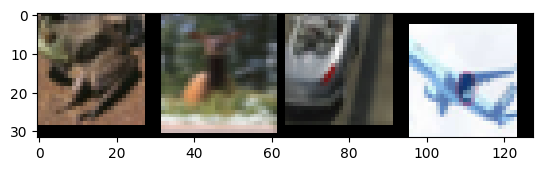

Class labels:  frog  deer  car   plane


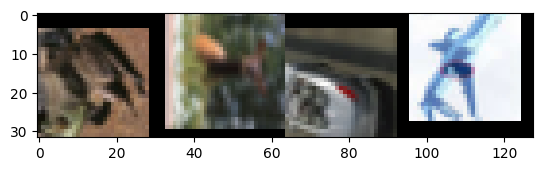

Rotation labels:  90    270   90    270  


In [15]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [20]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
           
            # Calculate outputs by running images through the network
            outputs = net(images)
            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')
    return 100 * correct / total, avg_test_loss

In [21]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18()


In [24]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)


In [25]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        acc_tot=[]
        loss_tot=[]
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get predicted results
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        acc,loss=run_test(net, testloader, criterion, task)
        acc_tot.append(acc)
        loss_tot.append(loss)

    print('maximum accuracy is: ',max(acc_tot))
    print('minimum loss is: ',min(loss_tot))
    print('Finished Training')

In [26]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

torch.save(net.state_dict(), 'model.pth')


[1,   100] loss: 1.567 acc: 36.42 time: 7.68
[1,   200] loss: 1.223 acc: 45.52 time: 5.93
[1,   300] loss: 1.148 acc: 49.95 time: 6.52
TESTING:
Accuracy of the network on the 10000 test images: 53.06 %
Average loss on the 10000 test images: 1.073
[2,   100] loss: 1.104 acc: 52.51 time: 7.84
[2,   200] loss: 1.090 acc: 53.21 time: 5.76
[2,   300] loss: 1.061 acc: 54.52 time: 6.79
TESTING:
Accuracy of the network on the 10000 test images: 56.12 %
Average loss on the 10000 test images: 1.067
[3,   100] loss: 1.037 acc: 55.91 time: 7.54
[3,   200] loss: 1.026 acc: 56.62 time: 5.69
[3,   300] loss: 1.026 acc: 56.10 time: 7.06
TESTING:
Accuracy of the network on the 10000 test images: 59.95 %
Average loss on the 10000 test images: 0.950
[4,   100] loss: 0.992 acc: 57.93 time: 7.70
[4,   200] loss: 0.992 acc: 57.93 time: 5.78
[4,   300] loss: 0.975 acc: 58.71 time: 7.48
TESTING:
Accuracy of the network on the 10000 test images: 60.39 %
Average loss on the 10000 test images: 0.961
[5,   100] l

In [ ]:
import torch
print(torch.__version__)

2.0.0+cu118


##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [27]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Define your ResNet18 model
model =resnet18()
# num_classes = 1000 # replace with the number of output classes
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
# Load the saved model weights
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
torch.autograd.detect_anomaly()

<ipython-input-20-7da50de8c1ba>:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  torch.autograd.detect_anomaly()


In [32]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [33]:
# Print all the trainable parameters
params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [34]:
# TODO: Define criterion and optimizer
import torch.optim as optim

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Define the optimizer; Only update the parameters that are trainable
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=0.001, momentum=0.9)


In [35]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01,
      task='classification')


[1,   100] loss: 2.767 acc: 34.14 time: 7.23
[1,   200] loss: 1.408 acc: 48.69 time: 5.31
[1,   300] loss: 1.350 acc: 50.42 time: 5.64
TESTING:
Accuracy of the network on the 10000 test images: 53.66 %
Average loss on the 10000 test images: 1.279
[2,   100] loss: 1.275 acc: 53.62 time: 6.38
[2,   200] loss: 1.272 acc: 53.70 time: 6.20
[2,   300] loss: 1.234 acc: 55.42 time: 5.27
TESTING:
Accuracy of the network on the 10000 test images: 56.89 %
Average loss on the 10000 test images: 1.192
[3,   100] loss: 1.203 acc: 56.84 time: 5.57
[3,   200] loss: 1.206 acc: 56.51 time: 6.96
[3,   300] loss: 1.182 acc: 57.13 time: 5.34
TESTING:
Accuracy of the network on the 10000 test images: 58.31 %
Average loss on the 10000 test images: 1.148
[4,   100] loss: 1.163 acc: 58.34 time: 5.47
[4,   200] loss: 1.174 acc: 57.83 time: 6.95
[4,   300] loss: 1.160 acc: 58.53 time: 5.21
TESTING:
Accuracy of the network on the 10000 test images: 59.93 %
Average loss on the 10000 test images: 1.100
[5,   100] l

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model

model = resnet18(pretrained=True)

# TODO: Randomly initialize a ResNet18 model
for param in model.layer4.parameters():
    param.requires_grad = True
    if param.dim() > 1:
        nn.init.kaiming_uniform_(param)

for param in model.fc.parameters():
    param.requires_grad = True
    if param.dim() > 1:
        nn.init.kaiming_uniform_(param)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 31.9MB/s]


In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Define the optimizer; Only update the parameters that are trainable
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=0.001, momentum=0.9)


In [ ]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, 
      task='classification')

[1,   100] loss: 2.123 acc: 40.07 time: 9.59
[1,   200] loss: 1.433 acc: 53.32 time: 8.50
[1,   300] loss: 1.368 acc: 56.19 time: 10.09
TESTING:
Accuracy of the network on the 10000 test images: 59.12 %
Average loss on the 10000 test images: 3.038
[2,   100] loss: 1.266 acc: 59.93 time: 9.48
[2,   200] loss: 1.270 acc: 59.30 time: 7.70
[2,   300] loss: 1.130 acc: 61.61 time: 9.47
TESTING:
Accuracy of the network on the 10000 test images: 63.68 %
Average loss on the 10000 test images: 1.142
[3,   100] loss: 1.073 acc: 63.47 time: 11.34
[3,   200] loss: 1.107 acc: 62.30 time: 7.73
[3,   300] loss: 1.068 acc: 63.63 time: 9.97
TESTING:
Accuracy of the network on the 10000 test images: 65.07 %
Average loss on the 10000 test images: 1.176
[4,   100] loss: 1.036 acc: 65.07 time: 11.01
[4,   200] loss: 1.010 acc: 65.20 time: 7.61
[4,   300] loss: 0.995 acc: 65.91 time: 9.21
TESTING:
Accuracy of the network on the 10000 test images: 66.13 %
Average loss on the 10000 test images: 1.221
[5,   100

##Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [36]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
model =resnet18()

# num_classes = 4 # replace with the number of output classes
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved model weights
model.load_state_dict(torch.load('model.pth'))

for param in model.parameters():
    param.requires_grad = True

In [37]:
# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Define the optimizer; Update all the parameters
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [38]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01,
      task='classification')

[1,   100] loss: 2.925 acc: 24.02 time: 7.16
[1,   200] loss: 1.685 acc: 37.53 time: 5.61
[1,   300] loss: 1.501 acc: 45.04 time: 7.35
TESTING:
Accuracy of the network on the 10000 test images: 50.36 %
Average loss on the 10000 test images: 1.348
[2,   100] loss: 1.285 acc: 53.78 time: 7.32
[2,   200] loss: 1.240 acc: 55.30 time: 5.65
[2,   300] loss: 1.182 acc: 57.08 time: 7.46
TESTING:
Accuracy of the network on the 10000 test images: 59.12 %
Average loss on the 10000 test images: 1.162
[3,   100] loss: 1.071 acc: 62.04 time: 7.39
[3,   200] loss: 1.034 acc: 62.71 time: 5.67
[3,   300] loss: 1.023 acc: 63.43 time: 7.33
TESTING:
Accuracy of the network on the 10000 test images: 64.12 %
Average loss on the 10000 test images: 1.017
[4,   100] loss: 0.947 acc: 66.20 time: 7.02
[4,   200] loss: 0.954 acc: 66.03 time: 5.59
[4,   300] loss: 0.934 acc: 66.76 time: 7.27
TESTING:
Accuracy of the network on the 10000 test images: 69.33 %
Average loss on the 10000 test images: 0.875
[5,   100] l

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
model = resnet18(pretrained=False)

for param in model.parameters():
    param.requires_grad = True
    if param.dim() > 1:
        nn.init.kaiming_uniform_(param)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Define the optimizer; Update all the parameters
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01,
      task='classification')

[1,   100] loss: 2.415 acc: 28.27 time: 8.72
[1,   200] loss: 1.692 acc: 39.41 time: 11.34
[1,   300] loss: 1.573 acc: 43.96 time: 10.31
TESTING:
Accuracy of the network on the 10000 test images: 49.51 %
Average loss on the 10000 test images: 1.442
[2,   100] loss: 1.420 acc: 49.30 time: 8.55
[2,   200] loss: 1.415 acc: 49.59 time: 11.52
[2,   300] loss: 1.350 acc: 52.51 time: 10.16
TESTING:
Accuracy of the network on the 10000 test images: 56.73 %
Average loss on the 10000 test images: 1.291
[3,   100] loss: 1.251 acc: 55.73 time: 8.52
[3,   200] loss: 1.217 acc: 56.69 time: 9.61
[3,   300] loss: 1.206 acc: 57.13 time: 10.05
TESTING:
Accuracy of the network on the 10000 test images: 62.05 %
Average loss on the 10000 test images: 1.107
[4,   100] loss: 1.109 acc: 60.55 time: 9.92
[4,   200] loss: 1.112 acc: 60.70 time: 8.53
[4,   300] loss: 1.106 acc: 60.72 time: 9.60
TESTING:
Accuracy of the network on the 10000 test images: 64.95 %
Average loss on the 10000 test images: 1.012
[5,   1

# **plotting**

**RotNet fine-tuning code**:
Fine-tuning on the pre-trained model(RotNet)

we loaded the pre-trained ResNet18 model(RotNet) and fine-tune on the classification task. 

# train on subset of dataset: 20 image

In [39]:
# 20 sunset of data 

trainset = CIFAR10Rotation(root='/content/drive/MyDrive/exam/cifar-10-batches-py',
                           train=True,download=True, transform=transform_train)
subset_indices = [ i for i in range(20)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


Files already downloaded and verified


In [53]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        acc_tot=[]
        loss_tot=[]
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get predicted results
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        acc,loss=run_test(net, testloader, criterion, task)
        acc_tot.append(acc)
        loss_tot.append(loss)

    print('maximum accuracy is: ',max(acc_tot))
    print('minimum loss is: ',min(loss_tot))
    print('Finished Training')

In [42]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model

model =resnet18()

# Load the saved model weights
model.load_state_dict(torch.load('model.pth'))

for param in model.parameters():
    param.requires_grad = True

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

TESTING:
Accuracy of the network on the 10000 test images: 9.38 %
Average loss on the 10000 test images: 13.207
TESTING:
Accuracy of the network on the 10000 test images: 8.28 %
Average loss on the 10000 test images: 15.290
TESTING:
Accuracy of the network on the 10000 test images: 9.33 %
Average loss on the 10000 test images: 17.923
TESTING:
Accuracy of the network on the 10000 test images: 8.68 %
Average loss on the 10000 test images: 19.129
TESTING:
Accuracy of the network on the 10000 test images: 10.56 %
Average loss on the 10000 test images: 20.257
TESTING:
Accuracy of the network on the 10000 test images: 11.32 %
Average loss on the 10000 test images: 20.607
TESTING:
Accuracy of the network on the 10000 test images: 12.79 %
Average loss on the 10000 test images: 21.324
TESTING:
Accuracy of the network on the 10000 test images: 14.38 %
Average loss on the 10000 test images: 20.808
TESTING:
Accuracy of the network on the 10000 test images: 15.54 %
Average loss on the 10000 test im

# train on subset of dataset: **100** image

In [43]:
# 100 sunset of data 

trainset = CIFAR10Rotation(root='/content/drive/MyDrive/exam/cifar-10-batches-py',
                           train=True,
                                        download=True, transform=transform_train)
subset_indices = [ i for i in range(100)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


Files already downloaded and verified


In [45]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01,
      task='classification')

TESTING:
Accuracy of the network on the 10000 test images: 13.02 %
Average loss on the 10000 test images: 4.960
TESTING:
Accuracy of the network on the 10000 test images: 13.03 %
Average loss on the 10000 test images: 4.737
TESTING:
Accuracy of the network on the 10000 test images: 13.07 %
Average loss on the 10000 test images: 4.576
TESTING:
Accuracy of the network on the 10000 test images: 13.61 %
Average loss on the 10000 test images: 4.461
TESTING:
Accuracy of the network on the 10000 test images: 14.75 %
Average loss on the 10000 test images: 4.393
TESTING:
Accuracy of the network on the 10000 test images: 15.53 %
Average loss on the 10000 test images: 4.350
TESTING:
Accuracy of the network on the 10000 test images: 16.21 %
Average loss on the 10000 test images: 4.306
TESTING:
Accuracy of the network on the 10000 test images: 16.47 %
Average loss on the 10000 test images: 4.221
TESTING:
Accuracy of the network on the 10000 test images: 16.42 %
Average loss on the 10000 test images

# train on subset of dataset: **400** image

In [46]:
# 400 sunset of data 
subset_indices = [ i for i in range(400)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


In [48]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01,
      task='classification')

TESTING:
Accuracy of the network on the 10000 test images: 20.71 %
Average loss on the 10000 test images: 3.083
TESTING:
Accuracy of the network on the 10000 test images: 22.87 %
Average loss on the 10000 test images: 2.698
TESTING:
Accuracy of the network on the 10000 test images: 25.75 %
Average loss on the 10000 test images: 2.473
TESTING:
Accuracy of the network on the 10000 test images: 26.45 %
Average loss on the 10000 test images: 2.250
TESTING:
Accuracy of the network on the 10000 test images: 26.08 %
Average loss on the 10000 test images: 2.154
TESTING:
Accuracy of the network on the 10000 test images: 24.11 %
Average loss on the 10000 test images: 2.193
TESTING:
Accuracy of the network on the 10000 test images: 25.36 %
Average loss on the 10000 test images: 2.179
TESTING:
Accuracy of the network on the 10000 test images: 28.82 %
Average loss on the 10000 test images: 2.062
TESTING:
Accuracy of the network on the 10000 test images: 30.06 %
Average loss on the 10000 test images

# train on subset of dataset: 1000 image

In [49]:
# 1000 sunset of data 

subset_indices = [ i for i in range(1000)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [51]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01,
      task='classification')

TESTING:
Accuracy of the network on the 10000 test images: 35.82 %
Average loss on the 10000 test images: 1.812
TESTING:
Accuracy of the network on the 10000 test images: 34.71 %
Average loss on the 10000 test images: 1.762
TESTING:
Accuracy of the network on the 10000 test images: 40.18 %
Average loss on the 10000 test images: 1.645
TESTING:
Accuracy of the network on the 10000 test images: 41.45 %
Average loss on the 10000 test images: 1.629
TESTING:
Accuracy of the network on the 10000 test images: 40.50 %
Average loss on the 10000 test images: 1.646
TESTING:
Accuracy of the network on the 10000 test images: 43.30 %
Average loss on the 10000 test images: 1.586
TESTING:
Accuracy of the network on the 10000 test images: 46.35 %
Average loss on the 10000 test images: 1.521
TESTING:
Accuracy of the network on the 10000 test images: 46.27 %
Average loss on the 10000 test images: 1.544
TESTING:
Accuracy of the network on the 10000 test images: 46.00 %
Average loss on the 10000 test images

# train on subset of dataset: 5000 image

In [52]:
# 5000 sunset of data 

subset_indices = [ i for i in range(5000)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [54]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, 
      task='classification')

TESTING:
Accuracy of the network on the 10000 test images: 20.96 %
Average loss on the 10000 test images: 2.224
TESTING:
Accuracy of the network on the 10000 test images: 33.08 %
Average loss on the 10000 test images: 1.741
TESTING:
Accuracy of the network on the 10000 test images: 39.86 %
Average loss on the 10000 test images: 1.650
TESTING:
Accuracy of the network on the 10000 test images: 44.25 %
Average loss on the 10000 test images: 1.519
TESTING:
Accuracy of the network on the 10000 test images: 47.08 %
Average loss on the 10000 test images: 1.472
TESTING:
Accuracy of the network on the 10000 test images: 48.57 %
Average loss on the 10000 test images: 1.437
TESTING:
Accuracy of the network on the 10000 test images: 48.37 %
Average loss on the 10000 test images: 1.448
TESTING:
Accuracy of the network on the 10000 test images: 53.45 %
Average loss on the 10000 test images: 1.313
TESTING:
Accuracy of the network on the 10000 test images: 57.00 %
Average loss on the 10000 test images

**supervised CIFAR10 model**:
we used Randomly initialize a ResNet18 model and re-train the whole model on the classification task. with out using pretrain model.

In [55]:
# 20 sunset of data 

trainset = CIFAR10Rotation(root='/content/drive/MyDrive/exam/cifar-10-batches-py',
                           train=True, download=True, transform=transform_train)
subset_indices = [ i for i in range(20)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


Files already downloaded and verified


In [69]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        acc_tot=[]
        loss_tot=[]
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get predicted results
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        acc,loss=run_test(net, testloader, criterion, task)
        acc_tot.append(acc)
        loss_tot.append(loss)

    print('maximum accuracy is: ',max(acc_tot))
    print('minimum loss is: ',min(loss_tot))
    print('Finished Training')

In [58]:
import torch.optim as optim

model = resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = True
    if param.dim() > 1:
        nn.init.kaiming_uniform_(param)

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()
# Define the optimizer; Update all the parameters
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01,
      task='classification')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


TESTING:
Accuracy of the network on the 10000 test images: 0.06 %
Average loss on the 10000 test images: 131.694
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 1932.524
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 20701.877
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 121953.141
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 331983.219
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 537380.000
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 626412.125
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 563704.625
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Aver

In [59]:
# 100 sunset of data 

trainset = CIFAR10Rotation(root='/content/drive/MyDrive/exam/cifar-10-batches-py', 
                           train=True,
                                        download=True, transform=transform_train)
subset_indices = [ i for i in range(100)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


Files already downloaded and verified


In [61]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, 
      task='classification')

TESTING:
Accuracy of the network on the 10000 test images: 13.53 %
Average loss on the 10000 test images: 1261.699
TESTING:
Accuracy of the network on the 10000 test images: 10.54 %
Average loss on the 10000 test images: 1165.566
TESTING:
Accuracy of the network on the 10000 test images: 10.55 %
Average loss on the 10000 test images: 1009.055
TESTING:
Accuracy of the network on the 10000 test images: 10.60 %
Average loss on the 10000 test images: 766.339
TESTING:
Accuracy of the network on the 10000 test images: 10.64 %
Average loss on the 10000 test images: 485.244
TESTING:
Accuracy of the network on the 10000 test images: 11.01 %
Average loss on the 10000 test images: 259.080
TESTING:
Accuracy of the network on the 10000 test images: 10.61 %
Average loss on the 10000 test images: 189.934
TESTING:
Accuracy of the network on the 10000 test images: 10.59 %
Average loss on the 10000 test images: 169.178
TESTING:
Accuracy of the network on the 10000 test images: 9.26 %
Average loss on the

In [62]:
# 400 sunset of data 

trainset = CIFAR10Rotation(root='/content/drive/MyDrive/exam/cifar-10-batches-py', 
                           train=True,
                                        download=True, transform=transform_train)
subset_indices = [ i for i in range(400)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [64]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, 
      task='classification')

TESTING:
Accuracy of the network on the 10000 test images: 10.93 %
Average loss on the 10000 test images: 6.020
TESTING:
Accuracy of the network on the 10000 test images: 11.77 %
Average loss on the 10000 test images: 4.179
TESTING:
Accuracy of the network on the 10000 test images: 10.08 %
Average loss on the 10000 test images: 3.284
TESTING:
Accuracy of the network on the 10000 test images: 10.09 %
Average loss on the 10000 test images: 2.801
TESTING:
Accuracy of the network on the 10000 test images: 10.99 %
Average loss on the 10000 test images: 2.904
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 2.995
TESTING:
Accuracy of the network on the 10000 test images: 12.22 %
Average loss on the 10000 test images: 2.948
TESTING:
Accuracy of the network on the 10000 test images: 11.05 %
Average loss on the 10000 test images: 3.327
TESTING:
Accuracy of the network on the 10000 test images: 10.39 %
Average loss on the 10000 test images

In [67]:
# 1000 sunset of data 

trainset = CIFAR10Rotation(root='/content/drive/MyDrive/exam/cifar-10-batches-py',
                           train=True,
                                        download=True, transform=transform_train)
subset_indices = [ i for i in range(1000)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, 
      task='classification')

TESTING:
Accuracy of the network on the 10000 test images: 36.60 %
Average loss on the 10000 test images: 1.781
TESTING:
Accuracy of the network on the 10000 test images: 37.02 %
Average loss on the 10000 test images: 1.660
TESTING:
Accuracy of the network on the 10000 test images: 39.04 %
Average loss on the 10000 test images: 1.636
TESTING:
Accuracy of the network on the 10000 test images: 40.19 %
Average loss on the 10000 test images: 1.631
TESTING:
Accuracy of the network on the 10000 test images: 40.70 %
Average loss on the 10000 test images: 1.608
TESTING:
Accuracy of the network on the 10000 test images: 39.61 %
Average loss on the 10000 test images: 1.651
TESTING:
Accuracy of the network on the 10000 test images: 41.02 %
Average loss on the 10000 test images: 1.606
TESTING:
Accuracy of the network on the 10000 test images: 40.58 %
Average loss on the 10000 test images: 1.672
TESTING:
Accuracy of the network on the 10000 test images: 42.38 %
Average loss on the 10000 test images

In [68]:
# 5000 sunset of data 

trainset = CIFAR10Rotation(root='/content/drive/MyDrive/exam/cifar-10-batches-py',
                           train=True,
                                        download=True, transform=transform_train)
subset_indices = [ i for i in range(5000)] # indices of the subset of data you want to use
subset_dataset = Subset(trainset, subset_indices)

trainloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [70]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01,
      task='classification')

TESTING:
Accuracy of the network on the 10000 test images: 13.30 %
Average loss on the 10000 test images: 3.064
TESTING:
Accuracy of the network on the 10000 test images: 13.74 %
Average loss on the 10000 test images: 2.371
TESTING:
Accuracy of the network on the 10000 test images: 16.06 %
Average loss on the 10000 test images: 2.844
TESTING:
Accuracy of the network on the 10000 test images: 20.10 %
Average loss on the 10000 test images: 2.770
TESTING:
Accuracy of the network on the 10000 test images: 17.84 %
Average loss on the 10000 test images: 2.471
TESTING:
Accuracy of the network on the 10000 test images: 20.18 %
Average loss on the 10000 test images: 2.357
TESTING:
Accuracy of the network on the 10000 test images: 20.93 %
Average loss on the 10000 test images: 2.798
TESTING:
Accuracy of the network on the 10000 test images: 21.08 %
Average loss on the 10000 test images: 3.867
TESTING:
Accuracy of the network on the 10000 test images: 21.29 %
Average loss on the 10000 test images

**plotting on one subset:**

**Comparing of pretained ResNet18 model and randomly intialized ResNet18 model**

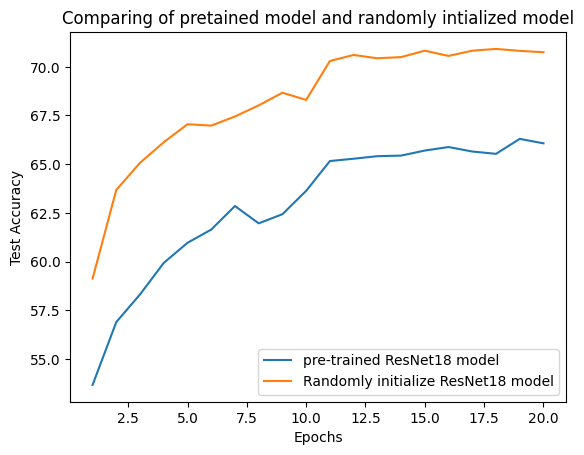

In [75]:
import matplotlib.pyplot as plt
epochs_Rotation  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
accuracy_Rotation = [53.66,56.89,58.31,59.93 ,60.96,61.64 ,62.85,61.96,62.43,63.63,65.16,65.28,65.41,65.44,65.70,65.88,65.65,65.53,66.30,66.07]

epochs_Randomly = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
accuracy_Randomly = [59.12,63.68,65.07,66.13,67.05, 66.98 ,67.45,68.02 ,68.67,68.30,70.30,70.61,70.44,70.50,70.83,70.56,70.83,70.92 ,70.82,70.75]

plt.plot(epochs_Rotation, accuracy_Rotation, label='pre-trained ResNet18 model')
plt.plot(epochs_Randomly, accuracy_Randomly, label='Randomly initialize ResNet18 model')
plt.title('Comparing of pretained model and randomly intialized model')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

**Comparing of pretained model and randomly intialized model in supervised model**

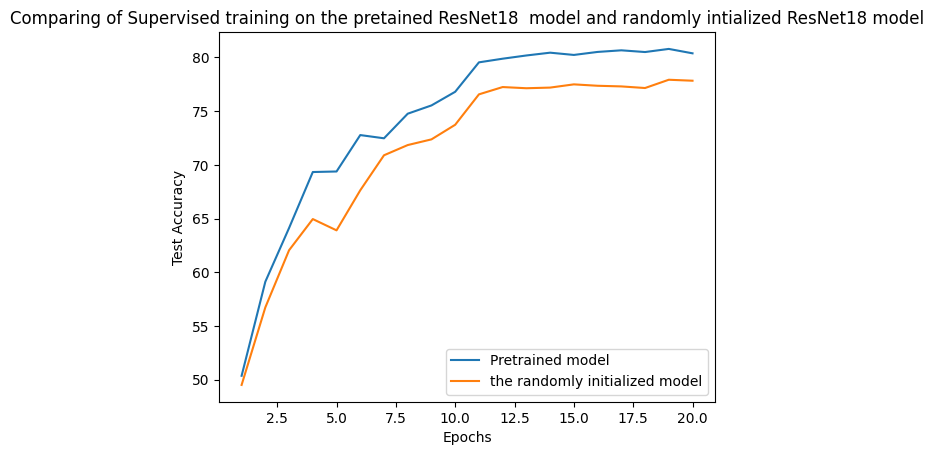

In [76]:
epochs_Rotation = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
accuracy_rotation = [50.36,59.12,64.12,69.33,69.38,72.77,72.47 ,74.76,75.53,76.80,79.54,79.88 ,80.18 ,80.44,80.23,80.51,80.66 ,80.50,80.79,80.38]


epochs_randomly = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
accuracy_randomly = [49.51,56.73,62.05,64.95,63.90, 67.63,70.89,71.84,72.37,73.73,76.56,77.24,77.13 ,77.19,77.49,77.36, 77.30,77.15,77.92,77.83]

plt.plot(epochs_Rotation, accuracy_rotation, label='Pretrained model')
plt.plot(epochs_randomly,accuracy_randomly , label='the randomly initialized model')
plt.title('Comparing of Supervised training on the pretained ResNet18  model and randomly intialized ResNet18 model')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

****plotting on the numbers of subset:****

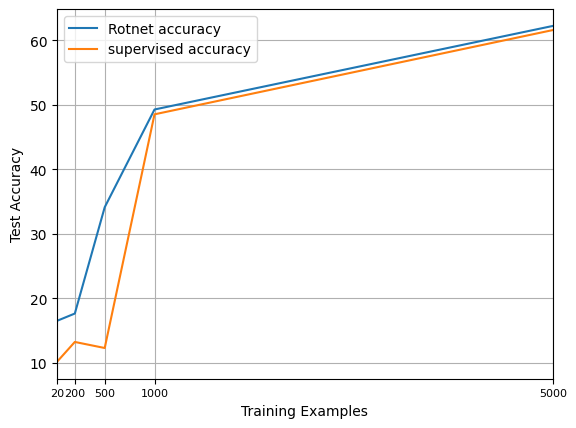

In [73]:
import matplotlib.pyplot as plt

x=[20,200,500,1000,5000]
Rotnet_accuracy=[16.47,17.61,34.11,49.28,62.25]
supervised_accuracy=[10.1,13.20,12.26,48.53,61.61]

plt.grid()
plt.plot(x,Rotnet_accuracy)
plt.plot(x,supervised_accuracy)

plt.xlabel('Training Examples')
plt.ylabel('Test Accuracy')

plt.xlim(20, 5000)
plt.xticks(x,fontsize=8)

plt.legend(['Rotnet accuracy','supervised accuracy'],loc='best')

plt.show()